# News spreading on youtube from US Channels


## Table of Contents
* [1 Preprocessing and data filtering](#filter_data)
    * [1.1 Filter for Category 'News & Politics'](#filter_data-category)
    * [1.2 Filter for Active Channels](#filter_data-active)
    * [1.3 Get country of channel](#filter_data-country)
    * [1.4 Get if channel is english-speaking](#filter_data-english)
    * [1.5 Filter for language and country and save final data](#filter_data-save)
        * [1.5.1 Filtering relevant comments](#filter_data-comments)
* [2 How US News report on different events](#status_quo)
    * [2.1 Get relevant videos per event](#status_quo-videos_per_event)
    * [2.2 Extract video and channel features](#status_quo-features)
        * [2.2.1 Intial distribution of video metrics](#status_quo-features-distributions)
    * [2.3 Results and Comparison between Events](#status_quo-results)
* [3 How does the public response to events](#public_response)
    * [3.1 Compute Public Response Metrics](#public_response-metrics)
    * [3.2 Compute Correlation between Video Features and Response Metrics](#public_response-correlation)
    * [3.3 Compute F- and T-tests](#public_response-ttest)
* [4 Conclusion](#conclusion)

**Global imports**

In [ ]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import importlib



from src.utils import keywords
from src.utils import analysis_tools
from src.scripts import filters
from src.plot_utils import channel_activity, filtering_visualization
from src.utils import general_utils

**Path definitions**

In [10]:
path_df_channels_en = 'data/df_channels_en.tsv'

path_df_timeseries = 'data/df_timeseries_en.tsv'

path_yt_metadata_feather = 'data/yt_metadata_helper.feather'
path_yt_metadata_feather_filtered = 'data/filtered_yt_metadata_helper.feather.csv'

path_yt_metadata = 'data/yt_metadata_en.jsonl'
path_yt_metadata_filtered = 'data/filtered_yt_metadata.csv'

path_final_channels = 'data/final_channels.csv'
path_final_timeseries = 'data/final_timeseries.csv'
path_final_yt_metadata_feather = 'data/final_yt_metadata_helper.csv'
path_final_yt_metadata = 'data/final_yt_metadata.csv'

## 1 Preprocessing and data filtering  <a class="anchor" id="filter_data"></a>



### 1.1 Filter for Category 'News & Politics' <a class="anchor" id="filter_data-category"></a>

The first step for filtering our data is to select only the channels which have been categorized as 'News & Politics'. This is done using `df_channels_en.tsv`.

In [3]:
pl_df_ch = pl.read_csv(path_df_channels_en, separator="\t")

filtered_df_ch = filters.filter_df(pl_df_ch, column_name="category_cc", 
                                   value="News & Politics", cmpstr="==")

print(f"Number of channels in category 'News & Politics': {len(filtered_df_ch)}")

Number of channels in category 'News & Politics': 2263


### 1.2 Filter for Active Channels <a class="anchor" id="filter_data-active"></a>

As we only want to focus on channels providing News Updates, we will compute the average activity of channel. This is defined as the average number of videos uploaded over two weeks and computed using the `df_timeseries_en.tsv`. We assumed that channels providing news *updates* will upload several videos per day. A manual review of some channels verified this assumption. To set a threshold we will plot the distribution to see if there is a clear separation between active and inactive channels. 

In [4]:
df_timeseries = pl.read_csv(path_df_timeseries, separator="\t")

# filter timeseries for channels in category 'News & Politics'
filtered_df_timeseries = filters.filter_df_isin(df_timeseries, column_name="channel", 
                                                values=filtered_df_ch["channel"])

In [1]:
# compute the average activity for all channels
grouped_df = filtered_df_timeseries.group_by('channel').agg(pl.col('activity').mean().alias('mean_activity'))
grouped_df.head(2)


channel,mean_activity
str,f64
"""UCQANb2YPwAtK-IQJrLaaUFw""",6.349515
"""UCEMnbZhWrFqp_LzBxei60cA""",19.093458


In [28]:
# merge the average activity with the filtered channels
merged_df = filtered_df_ch.join(grouped_df, on='channel', how='inner')
merged_df.head(2)

category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,mean_activity
str,str,str,str,i64,i64,f64,f64,f64
"""News & Politics""","""2006-08-26""","""UCttspZesZIDEwwpVIgoZtWQ""","""IndiaTV""",15177282,139814,199.0,2.087,596.564103
"""News & Politics""","""2012-06-01""","""UCRWFSbif-RFENbBrSiez1DA""","""ABP NEWS""",16274836,129027,207.0,2.087,595.458065


#### Test activity filter

Here we plot the distribution of the average number of videos uploaded over two weeks for all channels. 

In [ ]:
channel_activity.plot_channel_activity(pl_df_ch, df_timeseries, show=True, save_path='channels_activity_histogram.html')

**Conclusion**: We cannot identify clusters of active and non-active channels. That's why we set the cutoff threshold manually choosing a reasonable activity as threshold as 4 videos per day. This was verified manually by checking channels above the threshold. They mainly correspond to the type of news channels we were looking for.

#### Filter channels by activity

In [ ]:
# merge with channels dataframe
filtered_df_ch = filtered_df_ch.join(grouped_df, on="channel", how="inner")

# 56 = 4 videos per day x 14 days
filtered_df_ch = filters.filter_df(filtered_df_ch, "mean_activity", 56, ">")

# filtered_df_ch.sort(by="mean_activity", descending=True).head(10)

print("Number of channels in category 'News & Politics' with more than 4 videos per",\
      f"day: {len(filtered_df_ch)}")

Number of channels in category 'News & Politics' with more than 4 videos per day: 407


#### Filter yt_metadata by channels obtained before
To reduce the size of the big datasets `yt_metadata_en.jsonl` and `yt_metadata_helper.feather` we will prefilter them using the channels we obtained before. This will reduce the size of the dataset and make it easier to work with in future.

In [4]:
# Transform feather into csv to ease handling
df_vd_f = pd.read_feather(path_yt_metadata_feather)
# save to csv
df_vd_f.to_csv(path_yt_metadata_feather+".csv", sep="\t", index=False)

In [ ]:
# filter yt_metadata_helper.feather.csv by highly active news channels
filters.df_filter_csv_batched(path_yt_metadata_feather+".csv", path_yt_metadata_feather_filtered,
                              column_name="channel_id", values=filtered_df_ch["channel"],
                              filter_method="is_in")

In [ ]:
# Test if filtering worked by reading the previous saved file and printing the number of videos remaining
filtered_df_metadata_feather = pl.read_csv(path_yt_metadata_feather_filtered)
print("Number of videos from channels of interest (CoI): "\
      f"{len(filtered_df_metadata_feather)}")

Number of videos from channels of interest (CoI): 6812344


In [9]:
# same process for yt_metadata_en.jsonl
# we will also transform this file into a csv to unify file formats
filters.df_filter_jsonl_batched(path_yt_metadata, path_yt_metadata_filtered, 
                                column_name="channel_id", 
                                values=filtered_df_ch["channel"],
                                sep="\t", batch_size=500)

Empty DataFrame
Columns: [categories, channel_id, crawl_date, description, dislike_count, display_id, duration, like_count, tags, title, upload_date, view_count]
Index: []


### 1.3 Get country of channel <a class="anchor" id="filter_data-country"></a>

With the Youtube API we can query for the country information with the channel ID 

In [ ]:
high_activity_channels = filtered_df_ch.with_columns(
    pl.col("channel").map_elements(lambda channel_id:general_utils.get_channel_country(channel_id)).alias("Channel_country")
)

C:\Users\jeffr\AppData\Local\Temp\ipykernel_25620\2021680753.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  high_activity_channels = high_activity_channels.with_columns(


#### Example of filtered channel dataframe with country

In [ ]:
high_activity_channels.write_csv("data/high_activity_channels_with_country")
print(high_activity_channels.sample(10))


shape: (10, 10)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬─────────┬───────────┬───────────┐
│ category_c ┆ join_date ┆ channel   ┆ name_cc   ┆ … ┆ subscribe ┆ weights ┆ mean_acti ┆ Channel_c │
│ c          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ r_rank_sb ┆ ---     ┆ vity      ┆ ountry    │
│ ---        ┆ str       ┆ str       ┆ str       ┆   ┆ ---       ┆ f64     ┆ ---       ┆ ---       │
│ str        ┆           ┆           ┆           ┆   ┆ f64       ┆         ┆ f64       ┆ str       │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═════════╪═══════════╪═══════════╡
│ News &     ┆ 2017-02-1 ┆ UCMYlXK0j ┆ 10News    ┆ … ┆ 520837.0  ┆ 9.63    ┆ 93.886179 ┆ US        │
│ Politics   ┆ 7         ┆ yerVnc3dm ┆ WTSP      ┆   ┆           ┆         ┆           ┆           │
│            ┆           ┆ z-vjCA    ┆           ┆   ┆           ┆         ┆           ┆           │
│ News &     ┆ 2011-07-0 ┆ UCczsYSRG ┆ Himalaya  ┆ … ┆ 32797.0   ┆ 3.2005  

### 1.4 Get if channel is english-speaking with CHATGPT LLM API <a class="anchor" id="filter_data-english"></a>

Task: Use `filtered_yt_metadata.csv` and `high_activity_channels_with_country.csv` to filter for english videos

Since the youtube metadata dataset contains videos that are not from english speaking channels, we need to do further processing. We use the CHATGPT API to analyze 5 videos and descriptions and if any video is not classified as english, the channel is marked as non-english

#### Finding 5 videos that correspond to the high activity channels

In [ ]:
channels_df = pd.read_csv("data/high_activity_channels_with_country.csv") 
channel_ids = set(channels_df['channel'].unique())  
chunk_reader = pd.read_csv("data/filtered_yt_metadata.csv", chunksize=5000)

matching_videos = []
# dictionary to track how many videos are saved for each channel
channel_video_count = {channel_id: 0 for channel_id in channel_ids}

for chunk in chunk_reader:
    matching_rows = chunk[chunk['channel_id'].isin(channel_ids)]
    for channel_id, group in matching_rows.groupby('channel_id'):
        # if 5 videos are analyzed continue
        if channel_video_count[channel_id] >= 5:
            continue
        # get the first 5 videos for this channel, or fewer if there are less than 5
        first_5_videos = group.head(5 - channel_video_count[channel_id]) 
        channel_video_count[channel_id] += len(first_5_videos)
        matching_videos.append(first_5_videos)

final_df = pd.concat(matching_videos, ignore_index=True)
final_df.to_csv('data/matching_videos.csv', index=False)


#### Parsing the video title and description with CHATGPT API

In [ ]:
## TESTING THE FUNCTION 
final_df = pd.read_csv("data/matching_videos.csv")
result = general_utils.check_channel_english(final_df, "UClMs26ViHFMy7MS897Alcxw")

channel is english


#### Filtering the high activity channels with the check_channel_english function

In [ ]:
high_activity_channels = high_activity_channels.with_columns(
    pl.col("channel").map_elements(lambda channel_id:general_utils.check_channel_english(final_df, channel_id)).alias("Is_English")
)

In [ ]:
high_activity_channels.write_csv("data/high_activity_channels_country_and_english.csv")

#### Printing value counts for channels that are english and the country of origin

In [ ]:
filtered = pd.read_csv("data/high_activity_channels_country_and_english.csv")

In [3]:
english = filtered[filtered["Is_English"] == True]
print("English")
print(english["Channel_country"].value_counts())

English
Channel_country
US                   149
IN                    49
PK                    13
Channel not found      9
CA                     8
GB                     7
NG                     6
ZA                     4
KE                     4
PH                     3
CN                     3
FR                     2
GH                     2
IL                     2
MY                     2
QA                     1
UK                     1
CH                     1
UG                     1
BZ                     1
TR                     1
DE                     1
EC                     1
BD                     1
GU                     1
PG                     1
AU                     1
LK                     1
SG                     1
TH                     1
Name: count, dtype: int64


In [4]:
print(f"Number of English channels: {len(english)}")

Number of English channels: 278


### 1.5 Filter for language and country and save all the final dataframes <a class="anchor" id="filter_data-save"></a>

Now that we got all the information needed, we can filter all our dataframes and save them for future use. As a recall we are filtering for channels that are:
- categorized as 'News & Politics'
- active (more than 4 videos per day)
- english-speaking (predicted by CHATGPT API)
- from the US (fetched from the youtube API and completed manually)

In [ ]:
df_final_channels = pl.read_csv("data/high_activity_channels_country_and_english.csv", separator=",")
df_final_channels = df_final_channels.filter((pl.col("Channel_country") == "US") & (pl.col("Is_English") == True))
df_final_channels = df_final_channels.rename({"Is_English": "is_english", "Channel_country": "channel_country"})

df_final_channels.write_csv(path_final_channels, include_header=True, separator=",")

In [ ]:
# metadata feather
filters.df_filter_csv_batched(path_yt_metadata_feather_filtered, path_final_yt_metadata_feather,
                              column_name="channel_id", values=df_final_channels["channel"],
                              filter_method="is_in", sep_in="\t", sep_out=",")

In [ ]:
# metadata
df_final_yt_metadata = pl.read_csv(path_yt_metadata_filtered, has_header=True, 
                                   separator="\t", infer_schema=False)
df_final_yt_metadata = filters.filter_df_isin(df_final_yt_metadata, "channel_id", df_final_channels["channel"])
df_final_yt_metadata.write_csv(path_final_yt_metadata, include_header=True, separator=",")


In [ ]:
# timeseries
df_final_timeseries = pl.read_csv(path_df_timeseries, separator="\t", has_header=True)
df_final_timeseries = filters.filter_df_isin(df_final_timeseries, column_name="channel", 
                                                values=df_final_channels["channel"])
df_final_timeseries.write_csv(path_final_timeseries, include_header=True, separator=",")


Summary of Filtering:

In [ ]:
print("Final Number of videos from channels of interest (CoI): "\
      f"{len(df_final_yt_metadata)}")

print("Final channels of interest (CoI): "\
      f"{len(df_final_channels)}")

Final Number of videos from channels of interest (CoI): 2548064
Final channels of interest (CoI): 149


Visualization of filtering:
Steps:
1. Filter for 'News & Politics' category
2. Filter for active channels
3. Get country of channel
4. Get if channel is english-speaking

In [23]:
importlib.reload(filtering_visualization)
filtersteps_names = ["Category = News & Politics", "Activity > 4 videos/day", "Country =US", "English-speaking"]
coi_steps = [2263, 407, 278, 149]
filtering_visualization.plot_filtering_visualization(filtersteps_names, coi_steps, show=True, save_path="filtering_steps.html")

#### 1.5.1 Filtering relevant comments <a class="anchor" id="filter_data-comments"></a> 

We want to filter out the comments related the videos in the df_final_yt_metadata. To do this, we initially tried using our personal PCs to filter out the youtube_comments.tsv.gz dataset, but found that it would take too long for the scope of the project. To address this, we use AWS resources for more computational resources. The code in the below 3 cells is running on Amazon Sagemaker and the dataset is stored in a S3 bucket.

In [ ]:
import boto3
import polars as pl
import pandas as pd
import s3fs
from urllib.parse import urlparse

In [ ]:
# Define the S3 bucket name and any prefix you want to use
bucket_name = 'adaproject-lil0mohammedali'

# Initialize a session using Boto3
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

for obj in bucket.objects.filter():
    print(obj.key)


In [ ]:
s3_feather_path = "s3://adaproject-lil0mohammedali/final_yt_metadata_helper.csv"
filtered_df_metadata_feather = pl.read_csv(s3_feather_path)
s3_comments_path = "s3://adaproject-lil0mohammedali/youtube_comments.tsv.gz"

# Initialize S3 filesystem
fs = s3fs.S3FileSystem()

# Define S3 path and batch size
s3_path = s3_comments_path
batch_size = 8600000000/100000
total_batches = 8600000000/batch_size

s3_output_path = 's3://adaproject-lil0mohammedali/filtered_youtube_comments.tsv'  # Output path in S3

i = 0
# Open the output file on S3 for writing
with fs.open(s3_output_path, "wb") as output_file:
    # Open the input comments file on S3
    with fs.open(s3_comments_path, "rb") as f:
        for i, chunk in enumerate(
                pl.read_csv(f, sep='\t', compression='gzip', batch_size=batch_size,
            )):
            
            filtered_batch = chunk.filter(
                pl.col("video_id").is_in(filtered_df_metadata_feather["display_id"])
            )
            
            # For the first batch include the header; otherwise, append without header
            if i == 0:
                include_header = 1 
            else:
                include_header = 0
            filtered_batch.write_csv(output_file, include_header=include_header)
            
            print(f"Processed batch {i + 1} / {int(total_batches)} \r", end="")

## 2 How US News report on different events <a class="anchor" id="status_quo"></a>

### 2.1 Get relevant videos per event <a class="anchor" id="status_quo-videos_per_event"></a>


In [13]:
# load data in such a way to avoid errors
metadata = pl.read_csv(path_final_yt_metadata,  schema_overrides={
                                "dislike_count": pl.Float64,
                                "like_count": pl.Float64},
                                ignore_errors = True)

In [14]:
# counting erroneous like/dislike and date entries
keywords.summarize_outliers(metadata)

Total number of videos: 2,548,064
Date Outlier Count: 164,271
Like/Dislike Outlier Count (null elements): 223,686


In [15]:
# removing rows there the like or dislike entry is null, or where the date entry is erroneous (like "17")
metadata = keywords.filtering_bad_rows(metadata)

Original metadata shape: (2,548,064, 12)
New metadata shape: (2,324,376, 12)


In [16]:
keywords.summarize_outliers(metadata)

Total number of videos: 2,324,376
Date Outlier Count: 0
Like/Dislike Outlier Count (null elements): 0


In [17]:
## removing the hour time from the upload_date since it's always 00:00:00
metadata = keywords.remove_hour(metadata)

Event: 2016 US elections
Related videos found: 256,198
------------
Event: 2019 indian elections
Related videos found: 232,904
------------
Event: 2019 EU elections
Related videos found: 642
------------
Event: Venezuela Hyperinflation in 2018
Related videos found: 3,661
------------
Event: US-China trade war 2018
Related videos found: 156,707
------------
Event: Greece Economic Crisis 2015
Related videos found: 3,252
------------
Event: Hurricane Harvey (2017)
Related videos found: 2,573
------------
Event: Sulawesi Earthquake and Tsunami (2018)
Related videos found: 76
------------
Event: European Heatwaves (2019)
Related videos found: 314
------------
Event: 2017 battle of Raqqa (by US-led coalition)
Related videos found: 12,812
------------
Event: 2019 India-Pakistan Conflict (Pulwama and Balakot Airstrikes)
Related videos found: 118
------------
Event: 2015-2017 Rise in ISIS Attacks in Europe
Related videos found: 1,153
------------


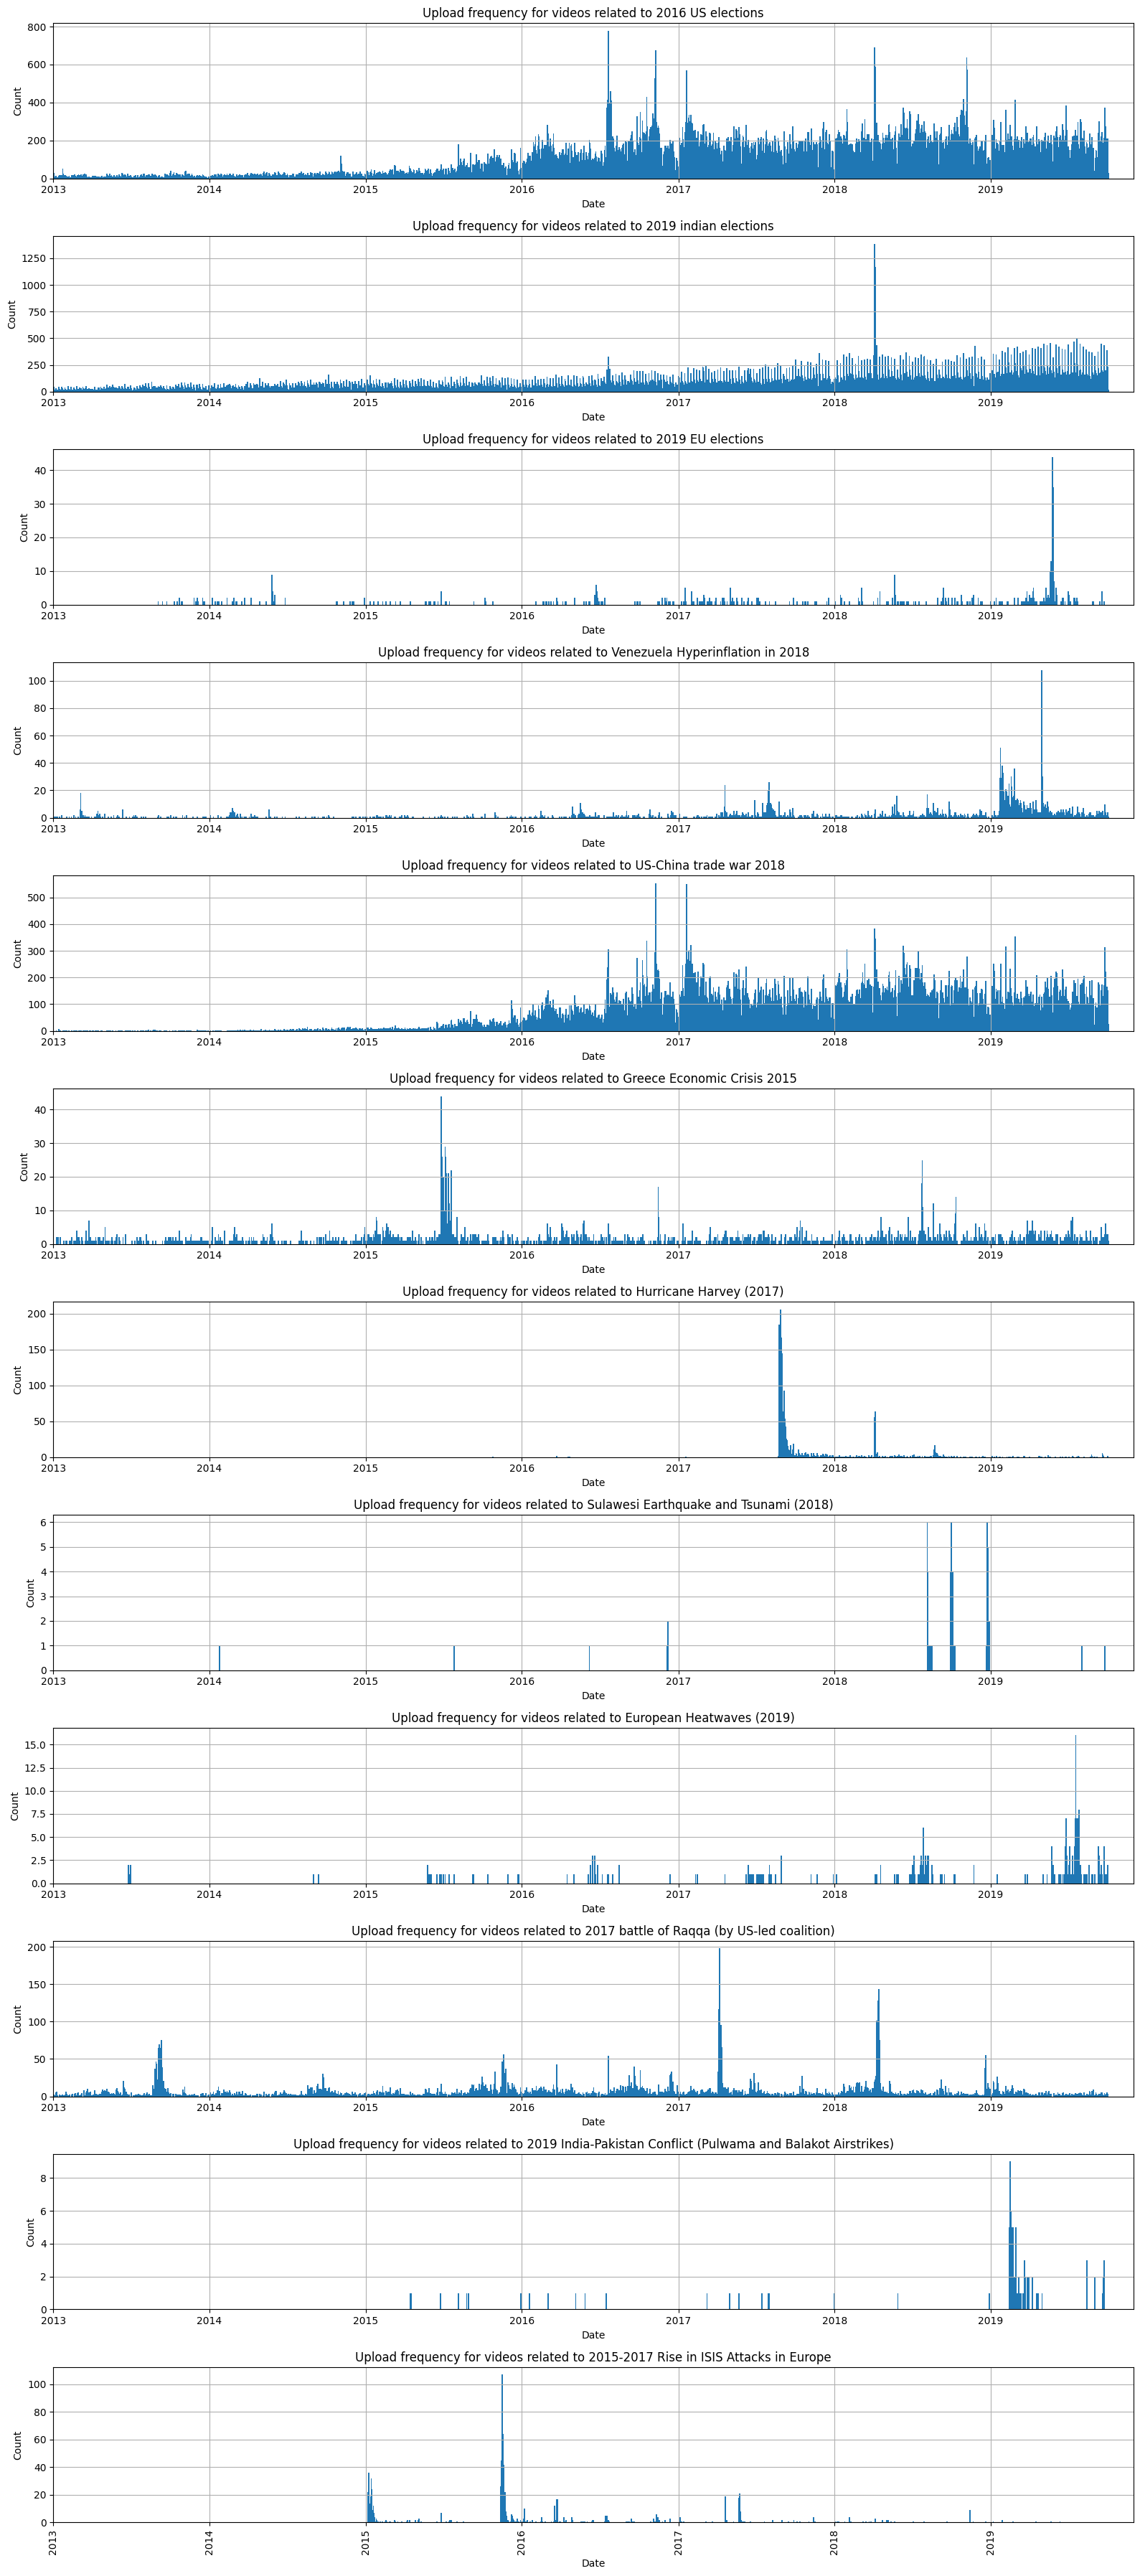

In [43]:
# plot the evolution of upload frequency for each event

index = 11       # 0-11, chooses event to plot. List is found in keywords.py
keywords.plot_update_frequ(index, metadata, all_plots = True, grouping_mode = "daily")
# all_plots = True to plot for all the events, disregards chosen index. Else plot for the even corresponding to chosen index
# grouping_mode: "daily", "weekly", "monthly"

In [ ]:

# TODO: add real values, here creating dummy df
import pandas as pd
import random

# Define the categories
event_types = ["geopolitical", "natural"]
event_locations = ["europe", "asia", "us"]
event_names = {
    "geopolitical": {
        "europe": ["Event 1 - geopolitical Europe", "Event 2 - geopolitical Europe", "Event 3 - geopolitical Europe"],
        "asia": ["Event 1 - geopolitical Asia", "Event 2 - geopolitical Asia", "Event 3 - geopolitical Asia"],
        "us": ["Event 1 - geopolitical US", "Event 2 - geopolitical US", "Event 3 - geopolitical US"]
    },
    "natural": {
        "europe": ["Event 1 - Natural Europe", "Event 2 - Natural Europe", "Event 3 - Natural Europe"],
        "asia": ["Event 1 - Natural Asia", "Event 2 - Natural Asia", "Event 3 - Natural Asia"],
        "us": ["Event 1 - Natural US", "Event 2 - Natural US", "Event 3 - Natural US"]
    }
}

# Generate random data for 10,000 entries
data = []

for _ in range(10000):
    event_type = random.choice(event_types)
    event_location = random.choice(event_locations)
    event_name = random.choice(event_names[event_type][event_location])
    data.append([event_location, event_type, event_name])

# Create the dataframe
df = pd.DataFrame(data, columns=["event_location", "event_type", "event_name"])

# Display the first few rows to verify
print(df["event_type"].value_counts())

event_type
geopolitical    5049
natural         4951
Name: count, dtype: int64


In [109]:
importlib.reload(filtering_visualization)
filtering_visualization.sankey_plot_events(df, show=True, save_path="event_filtering_sankey.html")

### 2.2 Extract video and channel features<a class="anchor" id="status_quo-features"></a>

In [18]:
#select the first features from the video metadata
#channel_id and display_id are for merging other dataframes
from src.utils.analysis_tools import *
timeseries_df = pl.read_csv(path_final_timeseries)
vid_features = metadata[['display_id','channel_id','duration']]

In [ ]:
#compute general statistics on the timeseries dataframe and add join them together
counts, means, stds, meds  = get_general_ch_statistics(timeseries_df,['delta_videos','subs'])
joined = counts.join(means, on='channel_id').rename({'delta_videos':'mean_delta_videos','subs':'mean_subs' })
joined = joined.join(stds, on='channel_id').rename({'delta_videos':'std_delta_videos','subs':'std_subs' })
joined = joined.join(meds, on='channel_id').rename({'delta_videos':'median_delta_videos','subs':'median_subs' })

In [ ]:
#merge the timeseries statistics with the video features daframe
vid_features = vid_features.join(joined, on='channel_id')
vid_features = vid_features.drop('channel_id')

In [ ]:
#compute the capitalization ratio of the title for each video (number of capital letters/number of lowercase letters) and add it to the dataframe
titles = metadata[['display_id','title']]
ratio = cap_ratio(titles, 'title')
ratio = ratio.drop('title')
vid_features = vid_features.join(ratio, on='display_id')

#### 2.2.1 Initial distributions of video metrics <a class="anchor" id="status_quo-features-distributions"></a>
In this section we want to show the distributions of all available video metrics. These metrics will later be used to catergorize the videos and the user resopnse to them. The plots here below are show the overall distribution over the whole filtered dataset, they build the baseline we can compare the response to specific events against.

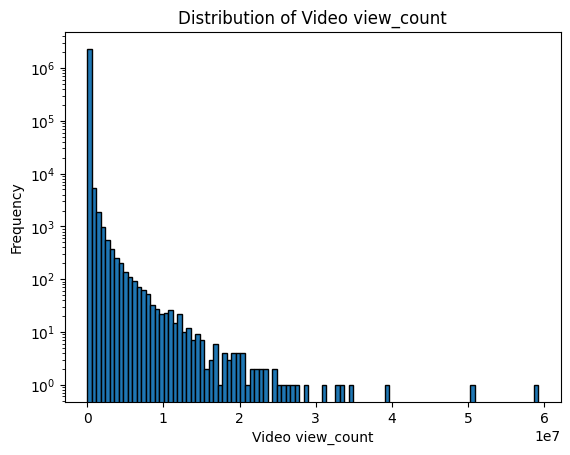

12 hours is the limit for livestream uploads


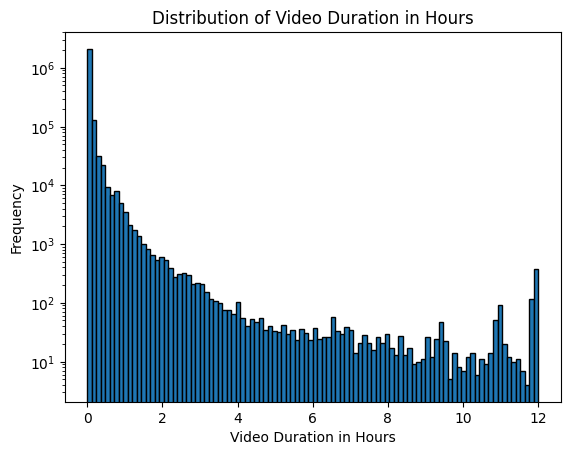

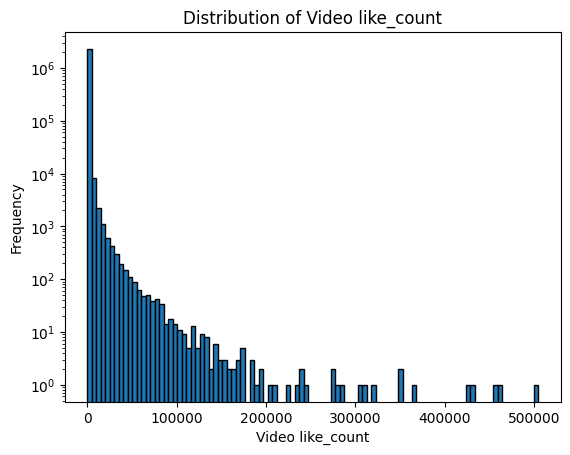

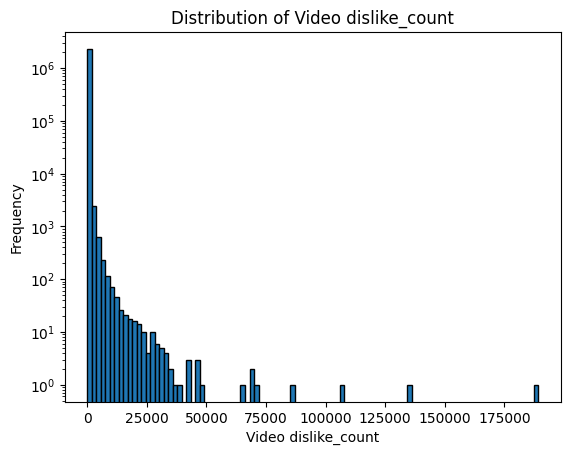

In [10]:
#plotting numerical distributions
analysis_tools.plot_video_stat(metadata, 'view_count')
analysis_tools.plot_video_stat(metadata, 'duration')
analysis_tools.plot_video_stat(metadata, 'like_count')
analysis_tools.plot_video_stat(metadata, 'dislike_count')

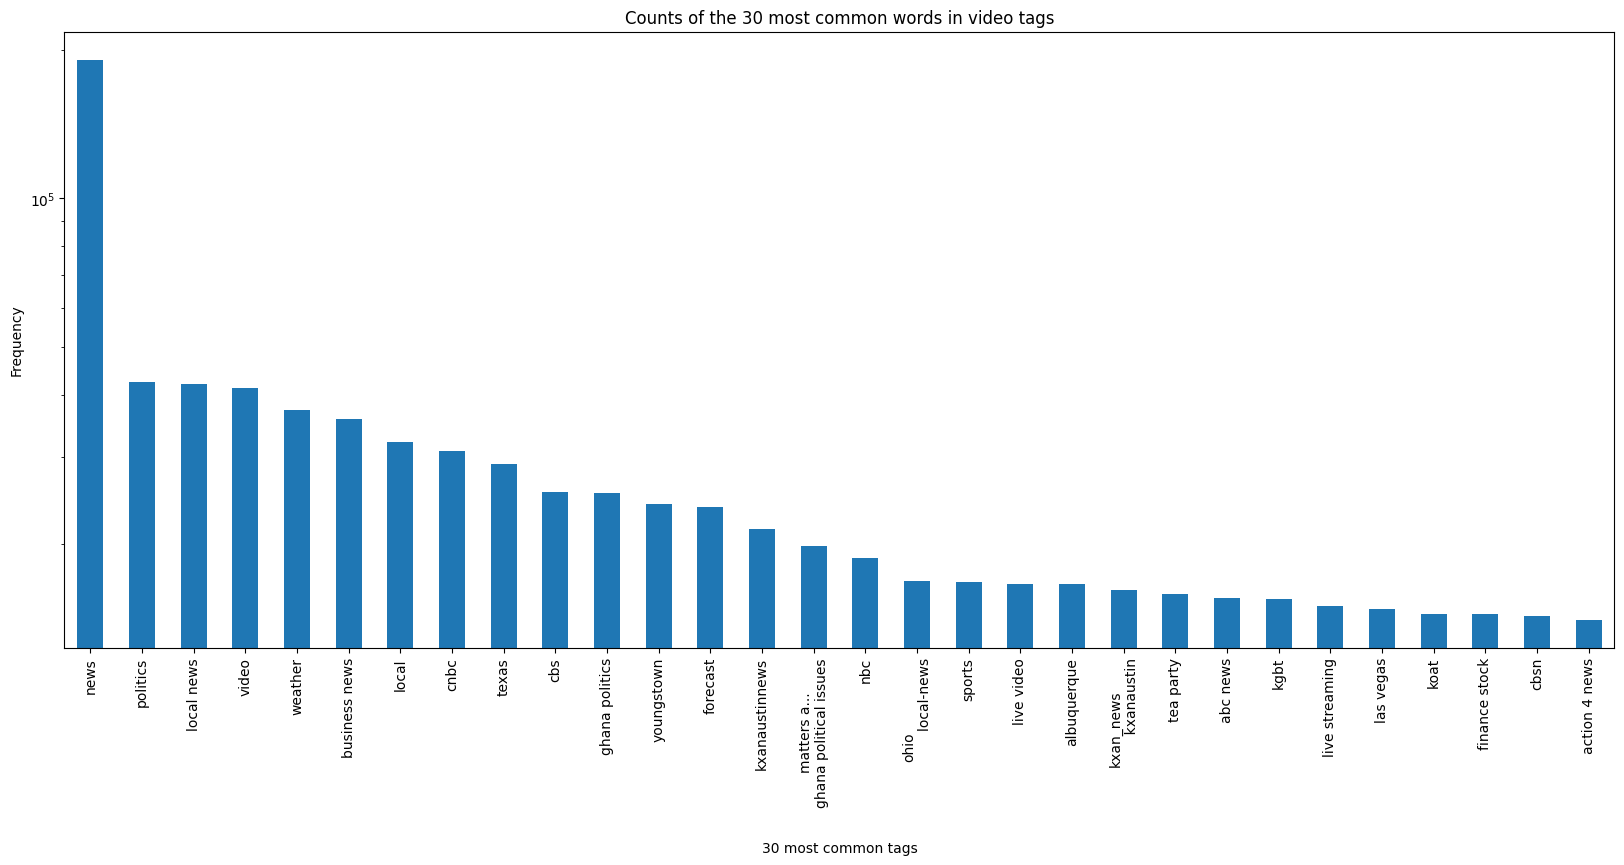

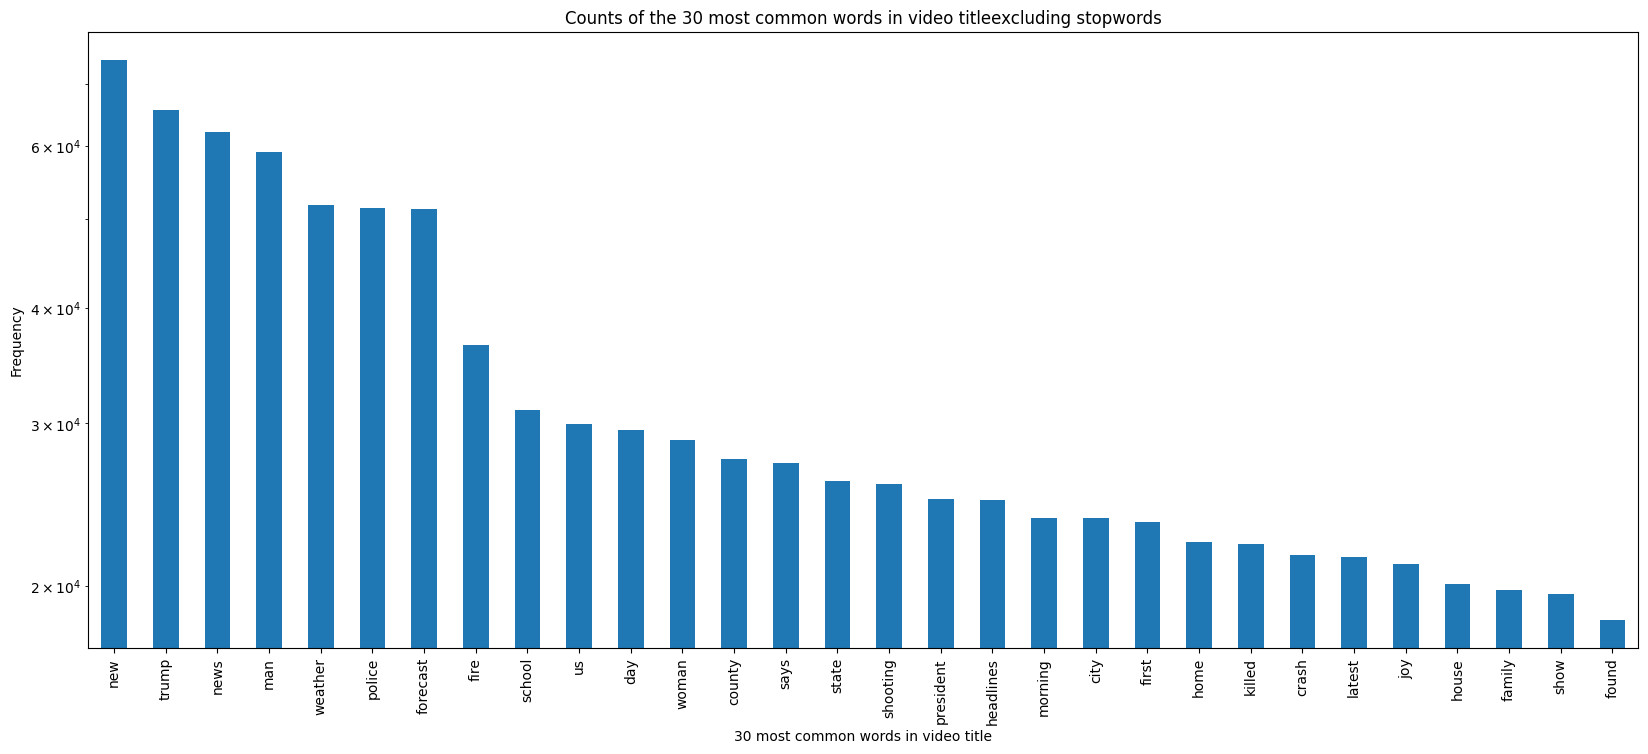

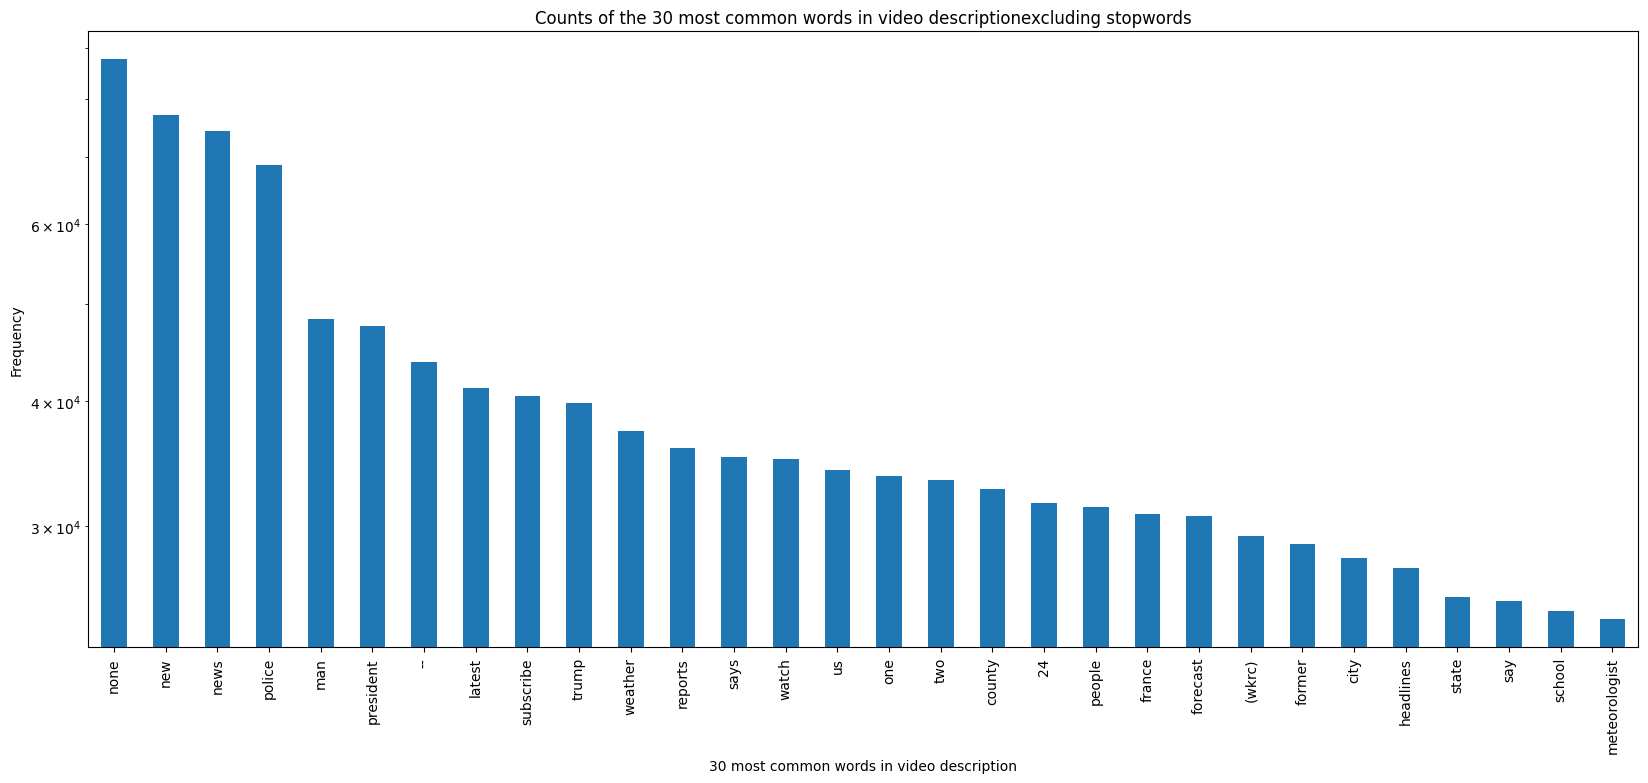

In [14]:
#plotting common words
analysis_tools.plot_most_common_tags(metadata, 30)
analysis_tools.plot_most_common_words(metadata, 'title', 30)
analysis_tools.plot_most_common_words(metadata, 'description', 30)

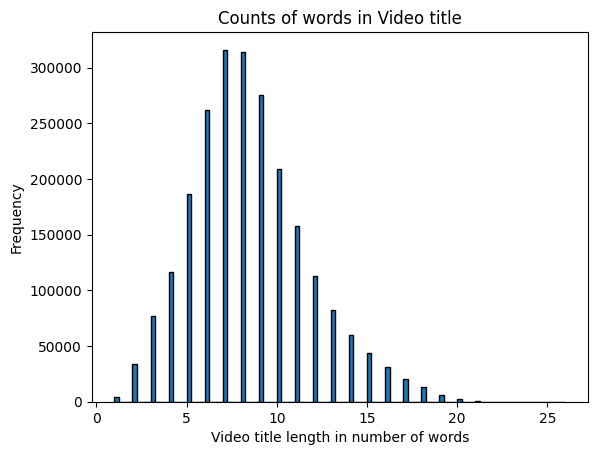

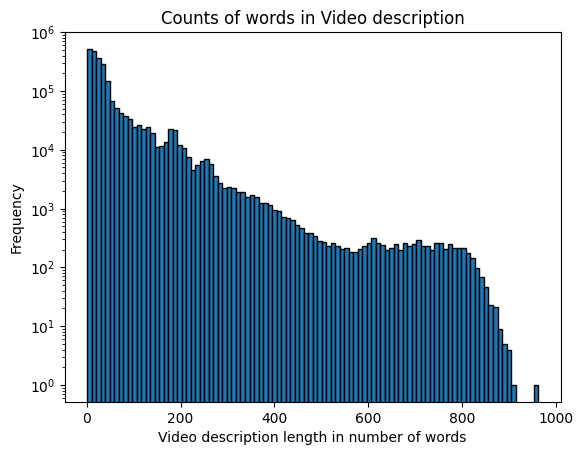

In [13]:
#plotting the length of titles and discriptions
analysis_tools.plot_text_len_words(metadata, 'title')
analysis_tools.plot_text_len_words(metadata, 'description')

### 2.3 Results and Comparison between Events <a class="anchor" id="status_quo-results"></a>

Getting correlation between the video features and plotting them.

Comparing which features appear most often in a given kind of event.

In [ ]:
get_general_vid_statistics(metadata)

In [ ]:
corr = plot_correlation_matrix(vid_features)

## 3 How does the public response to events <a class="anchor" id="public_response"></a>

In [ ]:
#adding num_comments to the metadata dataframe
num_comments = pl.read_csv('./data/num_comments.csv')
metadata = metadata.drop('num_comms_right')

In [137]:
#view counts in the previous metadata dataframe was found to have been saved wrongly as an int.
#we did not have time to fix this issue yet, but this is a dirty solution that allows for the rest of the code to work.
views = pl.read_csv(path_final_yt_metadata_feather)[['view_count','display_id']]
metadata = metadata.drop('view_count')
metadata = metadata.join(views, on='display_id')

In [8]:
#rename channel id columns to all have the same name
channels_df = channels_df.rename({'channel':'channel_id'})
timeseries_df = timeseries_df.rename({'channel':'channel_id'})

### 3.1 Compute Public Response Metrics <a class="anchor" id="public_response-metrics"></a>

In [138]:
#extract starting features from feather dataset
response_metrics = metadata.drop(['categories','channel_id','upload_date', 'duration','tags','description','title','crawl_date'])

#add a column for likes/dislikes ratio
response_metrics = response_metrics.with_columns((pl.col('like_count')/pl.col('dislike_count')).alias('Likes/Dislikes'))
response_metrics = response_metrics.drop(['like_count','dislike_count'])

#remove the entries with infinite like/dislike ratio, and set the NaNs to zero
print ('Number of entries before treating the Like/Dislike column:', len(response_metrics))
response_metrics = response_metrics.with_columns(pl.col('Likes/Dislikes').replace(np.NaN, 0))
response_metrics = response_metrics.filter(pl.col('Likes/Dislikes') != np.inf)
print ('Number of entries after treating the Like/Dislike column:', len(response_metrics))

Number of entries before treating the Like/Dislike column: 2324376
Number of entries after treating the Like/Dislike column: 1516647


#### Replies to comments and number of comments

The number of comments per video is given in `final_num_comments.csv`, so no need to compute them. For average replies per comment per video, we can compute it using `final_yt_comments.csv`.

**Disclaimer**:
At this point of our project we have not yet filtered the comments for the videos we are interested in. Therefore we will only propose a pipeline for the computation of the metrics.

In [ ]:
# load a sample comments dataset
path_final_comments = 'data/filtered_youtube_comments_example.tsv'

df_comments = pl.read_csv(path_final_comments, separator=",", has_header=True)

In [ ]:
replies_metrics = analysis_tools.comment_replies_metrics(df_comments)
response_metrics = response_metrics.join(replies_metrics, on="video_id", how="inner")
response_metrics

### 3.2 Compute Correlation between Video Features and Response Metrics <a class="anchor" id="public_response-correlation"></a>

In [140]:
#join the features and metric dataframes together
features_and_metrics = vid_features.join(response_metrics, on='display_id')

c:\Users\samue\anaconda3\envs\adaenv\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


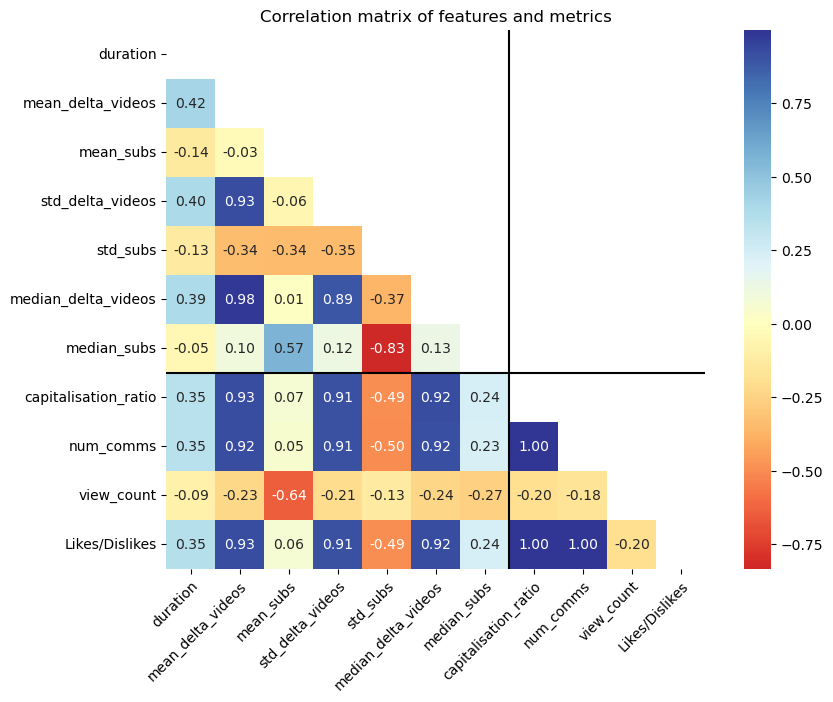

In [142]:
corr_1 = plot_correlation_matrix_features_and_metrics(features_and_metrics,7)

### 3.3 Compute F- and T-tests <a class="anchor" id="public_response-ttest"></a>

After computing the correlation between the video features and the response variables, we can analyse the significance of the correlation with statistical tests. We have a pipeline designed and a few functions coded to perform this analysis.
We will implement those in order to determine which video features should be optimized in order to expect a better video performance in a given metric.

## 4 Conclusion <a class="anchor" id="conclusion"></a>

In this notebook, we filtered the channels, metadata and times-series by keeping the videos from US, English-speaking channels with the category of News and Politics, keeping only high activity channels. Filtering of the massive comments dataset from these channels will be done on AWS, and we will study the reporting of the different events, ultimate grouping them by event category and country of occurrence to draw meaningful patterns, and we will also study how different video formats, types, and other characteristics affect the response of the public in terms of virality as well as the breadth of discussions that are illicited in the comments. We were able to isolate the videos related to each event by writing a list of terms that are respectively relevant to said events (while minimizing overlapping with other events as to not flag irrelevant videos), and searching for them in the titles and descriptions.